# 「室内設備」特徴量を抽出してみる！

In [88]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
train_df = pd.read_csv("../data/outer_data/train.csv")
test_df = pd.read_csv('../data/outer_data/test.csv')

In [90]:
train_df.head(2)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間


### テキスト整形用関数群

In [91]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

「室内設備」特徴量について下準備

In [92]:
room_equip = train_df['室内設備']

In [93]:
for i in range(len(room_equip)):
    try:
        room_equip.loc[i] = clean_text(room_equip.loc[i])
        room_equip.loc[i] = room_equip.loc[i].replace('／', '')
        room_equip.loc[i] = room_equip.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_equip.loc[i] = clean_text(room_equip.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_equip.loc[i] = room_equip.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [94]:
from cmath import nan


equipments = []
for i in range(len(room_equip)):
    text = room_equip.loc[i]
    equipments_list = []
    try:
        if 'エアコン付' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)
        
        if 'シューズボックス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'バルコニー' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'フローリング' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '室内洗濯機置場' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '敷地内ごみ置き場' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if ('エレベータ' in text) or ('エレベーター' in text):
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '公営水道' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '水道その他' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '下水' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '汲み取り' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '都市ガス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'プロパンガス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'タイル張' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ウォークインクローゼット' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '2面採光' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '3面採光' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '24時間換気システム' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ペアガラス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '庭' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'クッションフロア' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '床暖房' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ロフト' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '出窓' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'トランクルーム' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'オール電化' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

    except:#「キッチン」特徴量に何も記載がない場合
        equipments_list = [0 for k in range(26)] #ホントに0埋めで良いの？

    equipments.append( equipments_list )

equipments = pd.DataFrame( equipments )

In [95]:
equipments.columns = ['エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
'敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
'出窓','トランクルーム','オール電化']

In [96]:
equipments.to_csv('../data/handmade_data/equipments.csv',index=False)

In [97]:
equipments[equipments['汲み取り']==1]

,エアコン付,シューズボックス,バルコニー,フローリング,室内洗濯機置場,敷地内ごみ置き場,エレベーター,公営水道,水道その他,下水,...,3面採光,24時間換気システム,ペアガラス,庭,クッションフロア,床暖房,ロフト,出窓,トランクルーム,オール電化
44,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4240,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4500,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11807,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
13792,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


テストデータにも同じことをする

In [98]:
room_equip = test_df['室内設備']

In [99]:
for i in range(len(room_equip)):
    try:
        room_equip.loc[i] = clean_text(room_equip.loc[i])
        room_equip.loc[i] = room_equip.loc[i].replace('／', '')
        room_equip.loc[i] = room_equip.loc[i].replace('\t', ' ')
    except:
        pass

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_equip.loc[i] = clean_text(room_equip.loc[i])
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_equip.loc[i] = room_equip.loc[i].replace('／', '')
/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_2680/1146119556.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [100]:
from cmath import nan


equipments = []
for i in range(len(room_equip)):
    text = room_equip.loc[i]
    equipments_list = []
    try:
        if 'エアコン付' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)
        
        if 'シューズボックス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'バルコニー' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'フローリング' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '室内洗濯機置場' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '敷地内ごみ置き場' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if ('エレベータ' in text) or ('エレベーター' in text):
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '公営水道' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '水道その他' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '下水' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '汲み取り' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '都市ガス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'プロパンガス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'タイル張' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ウォークインクローゼット' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '2面採光' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '3面採光' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '24時間換気システム' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ペアガラス' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '庭' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'クッションフロア' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '床暖房' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'ロフト' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if '出窓' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'トランクルーム' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

        if 'オール電化' in text:
            equipments_list.append(1)
        else:
            equipments_list.append(0)

    except:#「キッチン」特徴量に何も記載がない場合
        equipments_list = [0 for k in range(26)] #ホントに0埋めで良いの？

    equipments.append( equipments_list )

equipments = pd.DataFrame( equipments )

In [101]:
equipments.columns = ['エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
'敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
'出窓','トランクルーム','オール電化']

In [102]:
equipments.to_csv('../data/test_data/test_equipments.csv',index=False)

In [103]:
equipments[equipments['汲み取り']==1]

,エアコン付,シューズボックス,バルコニー,フローリング,室内洗濯機置場,敷地内ごみ置き場,エレベーター,公営水道,水道その他,下水,...,3面採光,24時間換気システム,ペアガラス,庭,クッションフロア,床暖房,ロフト,出窓,トランクルーム,オール電化
3635,0,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
11199,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
12617,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13486,1,1,1,1,1,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
21618,0,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24897,1,1,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### この特徴量を使ってLightGBMのGBDTを動かしてみる

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
equipments = pd.read_csv('../data/handmade_data/equipments.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points, equipments], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points, test_equipments], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 
'エアコン付','シューズボックス','バルコニー','フローリング','室内洗濯機置場',
'敷地内ごみ置き場','エレベーター','公営水道','水道その他','下水','汲み取り','都市ガス','プロパンガス','タイル張',
'ウォークインクローゼット','2面採光','3面採光','24時間換気システム','ペアガラス','庭','クッションフロア','床暖房','ロフト',
'出窓','トランクルーム','オール電化']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2783
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 53
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48825.8	valid_1's rmse: 50155.6


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'クッションフロア', 'シューズボックス', 'タイル張', 'トランクルーム', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '公営水道', '出窓', '定期借家', '室内洗濯機置場', '床暖房', '庭', '建物構造', '所在地', '敷地内ごみ置き場', '最寄り駅', '水道その他', '汲み取り', '都市ガス']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[20]	training's rmse: 34591.4	valid_1's rmse: 37766.5
[30]	training's rmse: 26122.1	valid_1's rmse: 30841.3
[40]	training's rmse: 21116.9	valid_1's rmse: 27049.7
[50]	training's rmse: 17921.6	valid_1's rmse: 24740.3
[60]	training's rmse: 15934.4	valid_1's rmse: 23257.6
[70]	training's rmse: 14525.8	valid_1's rmse: 22226.3
[80]	training's rmse: 13558.9	valid_1's rmse: 21585
[90]	training's rmse: 12741.1	valid_1's rmse: 21064.5
[100]	training's rmse: 12098.1	valid_1's rmse: 20656.3
[110]	training's rmse: 11528.4	valid_1's rmse: 20250.6
[120]	training's rmse: 11041.6	valid_1's rmse: 19892.1
[130]	training's rmse: 10657.7	valid_1's rmse: 19667.2
[140]	training's rmse: 10287.5	valid_1's rmse: 19444.2
[150]	training's rmse: 9972.15	valid_1's rmse: 19278.6
[160]	training's rmse: 9672	valid_1's rmse: 19115.9
[170]	training's rmse: 9383.63	valid_1's rmse: 18935.9
[180]	training's rmse: 9124.08	valid_1's rmse: 18775.3
[190]	training's rmse: 8903.48	valid_1's rmse: 18639.8
[200]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'クッションフロア', 'シューズボックス', 'タイル張', 'トランクルーム', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '公営水道', '出窓', '定期借家', '室内洗濯機置場', '床暖房', '庭', '建物構造', '所在地', '敷地内ごみ置き場', '最寄り駅', '水道その他', '汲み取り', '都市ガス']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[20]	training's rmse: 34889.6	valid_1's rmse: 35681.6
[30]	training's rmse: 26752.3	valid_1's rmse: 28085.9
[40]	training's rmse: 21919.1	valid_1's rmse: 23804.9
[50]	training's rmse: 19049.1	valid_1's rmse: 21160.7
[60]	training's rmse: 17193.1	valid_1's rmse: 19761.4
[70]	training's rmse: 15835.9	valid_1's rmse: 18885.5
[80]	training's rmse: 14835.1	valid_1's rmse: 18202.9
[90]	training's rmse: 14015.6	valid_1's rmse: 17827.9
[100]	training's rmse: 13359.4	valid_1's rmse: 17587.2
[110]	training's rmse: 12812.4	valid_1's rmse: 17465.4
[120]	training's rmse: 12345.7	valid_1's rmse: 17335
[130]	training's rmse: 11884.7	valid_1's rmse: 17316.2
[140]	training's rmse: 11484.1	valid_1's rmse: 17262
[150]	training's rmse: 11099.3	valid_1's rmse: 17218.6
[160]	training's rmse: 10741.2	valid_1's rmse: 17193.5
[170]	training's rmse: 10420.5	valid_1's rmse: 17161.8
Early stopping, best iteration is:
[168]	training's rmse: 10499.8	valid_1's rmse: 17154
Start training...
[LightGBM] [Warning] Auto-

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'クッションフロア', 'シューズボックス', 'タイル張', 'トランクルーム', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '公営水道', '出窓', '定期借家', '室内洗濯機置場', '床暖房', '庭', '建物構造', '所在地', '敷地内ごみ置き場', '最寄り駅', '水道その他', '汲み取り', '都市ガス']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[10]	training's rmse: 48908.9	valid_1's rmse: 48908.4
[20]	training's rmse: 35042.8	valid_1's rmse: 34765.2
[30]	training's rmse: 26799.2	valid_1's rmse: 26985.5
[40]	training's rmse: 22030.5	valid_1's rmse: 22852.9
[50]	training's rmse: 19033.2	valid_1's rmse: 20430.6
[60]	training's rmse: 17129.1	valid_1's rmse: 19194
[70]	training's rmse: 15819.4	valid_1's rmse: 18503.5
[80]	training's rmse: 14856.4	valid_1's rmse: 18049.6
[90]	training's rmse: 14010.4	valid_1's rmse: 17797.7
[100]	training's rmse: 13369.7	valid_1's rmse: 17593.9
[110]	training's rmse: 12831.9	valid_1's rmse: 17489.3
[120]	training's rmse: 12366.9	valid_1's rmse: 17448.5
[130]	training's rmse: 11917.9	valid_1's rmse: 17373.9
[140]	training's rmse: 11514.2	valid_1's rmse: 17302.6
[150]	training's rmse: 11125.1	valid_1's rmse: 17215.3
[160]	training's rmse: 10794.3	valid_1's rmse: 17238.9
Early stopping, best iteration is:
[150]	training's rmse: 11125.1	valid_1's rmse: 17215.3
Start training...
[LightGBM] [Warning] Au

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'クッションフロア', 'シューズボックス', 'タイル張', 'トランクルーム', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '公営水道', '出窓', '定期借家', '室内洗濯機置場', '床暖房', '庭', '建物構造', '所在地', '敷地内ごみ置き場', '最寄り駅', '水道その他', '汲み取り', '都市ガス']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[20]	training's rmse: 34730	valid_1's rmse: 35638.6
[30]	training's rmse: 26178.1	valid_1's rmse: 28718.5
[40]	training's rmse: 21274.9	valid_1's rmse: 25099.4
[50]	training's rmse: 18210.2	valid_1's rmse: 23153.9
[60]	training's rmse: 16316.8	valid_1's rmse: 22101.1
[70]	training's rmse: 15064.8	valid_1's rmse: 21621.2
[80]	training's rmse: 14162.7	valid_1's rmse: 21208.5
[90]	training's rmse: 13442.1	valid_1's rmse: 20968.2
[100]	training's rmse: 12840.3	valid_1's rmse: 20770
[110]	training's rmse: 12342.2	valid_1's rmse: 20637.3
[120]	training's rmse: 11900.1	valid_1's rmse: 20529.3
[130]	training's rmse: 11503.3	valid_1's rmse: 20342
[140]	training's rmse: 11122.5	valid_1's rmse: 20219.5
[150]	training's rmse: 10804.6	valid_1's rmse: 20112.7
[160]	training's rmse: 10521	valid_1's rmse: 20076.8
[170]	training's rmse: 10224	valid_1's rmse: 19977.1
[180]	training's rmse: 9965.52	valid_1's rmse: 19925.9
[190]	training's rmse: 9706.02	valid_1's rmse: 19867.9
[200]	training's rmse: 9481.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '24時間換気システム', '2面採光', '3面採光', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'ウォークインクローゼット', 'エアコン付', 'エレベーター', 'オール電化', 'クッションフロア', 'シューズボックス', 'タイル張', 'トランクルーム', 'バス・トイレ別', 'バルコニー', 'フローリング', 'プロパンガス', 'ペアガラス', 'ロフト', '下水', '公営水道', '出窓', '定期借家', '室内洗濯機置場', '床暖房', '庭', '建物構造', '所在地', '敷地内ごみ置き場', '最寄り駅', '水道その他', '汲み取り', '都市ガス']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[20]	training's rmse: 35088.3	valid_1's rmse: 37071.4
[30]	training's rmse: 26970.1	valid_1's rmse: 28604.4
[40]	training's rmse: 22336.3	valid_1's rmse: 23671.9
[50]	training's rmse: 19152.7	valid_1's rmse: 20762
[60]	training's rmse: 17219.9	valid_1's rmse: 19306.4
[70]	training's rmse: 15922.6	valid_1's rmse: 18398.7
[80]	training's rmse: 14919	valid_1's rmse: 17800.6
[90]	training's rmse: 14137.4	valid_1's rmse: 17343.3
[100]	training's rmse: 13536.5	valid_1's rmse: 17072.1
[110]	training's rmse: 13034.4	valid_1's rmse: 16887.3
[120]	training's rmse: 12586.6	valid_1's rmse: 16711.7
[130]	training's rmse: 12152	valid_1's rmse: 16546.6
[140]	training's rmse: 11761.1	valid_1's rmse: 16395.4
[150]	training's rmse: 11386.8	valid_1's rmse: 16270.4
[160]	training's rmse: 11075.8	valid_1's rmse: 16164.2
[170]	training's rmse: 10764.9	valid_1's rmse: 16048.3
[180]	training's rmse: 10487.8	valid_1's rmse: 15953.2
[190]	training's rmse: 10232.8	valid_1's rmse: 15859
[200]	training's rmse: 100

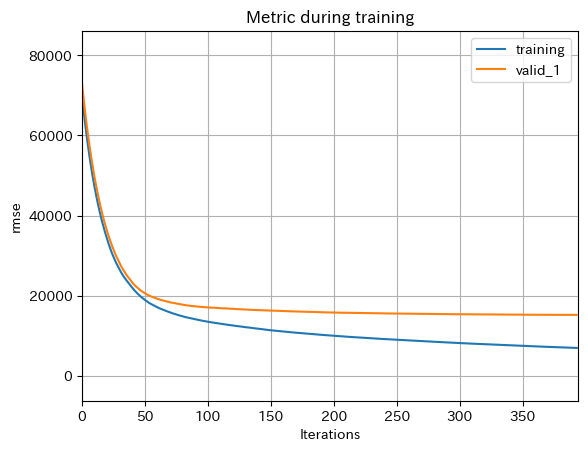

,importance
面積,4.512491e+14
L,3.945234e+14
平均地価,1.995683e+14
最寄り駅,9.368092e+13
築年数,6.464511e+13
所在地,3.736762e+13
一部屋あたりの面積,2.432307e+13
全体の階数,2.237921e+13
契約期間,1.375573e+13
所在階,1.135697e+13


In [107]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

# 室内設備はあっても良いかも